# Импорты для сети

In [1]:
import tensorflow as tf
import cv2
import os
import sys
import random
import numpy as np
import glob

from tqdm import tqdm
import tifffile as tif
from PIL import Image
from skimage.io import imread,imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.models import Model

%matplotlib inline

# Подготовим картинки

In [2]:
def prep_image(image, size_y, size_x):
    prepd_image = cv2.resize(image,(size_y, size_x))
    return prepd_image

size_x=128
size_y=128


train_images=[]

for directory_path in glob.glob("Water Bodies Dataset/Images"):
    for img_path in glob.glob(os.path.join(directory_path,"*.jpg")):
        img=cv2.imread(img_path,cv2.IMREAD_COLOR)
        img=prep_image(img,size_y,size_x)
        train_images.append(img)
        
train_images = np.array(train_images)

train_masks = []

for directory_path in glob.glob("Water Bodies Dataset/Masks"):
    for mask_path in glob.glob(os.path.join(directory_path,"*.jpg")):
        mask=cv2.imread(mask_path,0)
        mask=prep_image(mask,size_y,size_x)
        train_masks.append(mask)
        
train_masks = np.array(train_masks)

# Проверим

In [3]:
len(train_images), len(train_masks)

(2820, 2820)

In [4]:
train_images[0].shape, train_masks[0].shape

((128, 128, 3), (128, 128))

In [3]:
# Нормализуем
x = train_images/255
y = train_masks/255

## Выведем случайную пикчу и маску

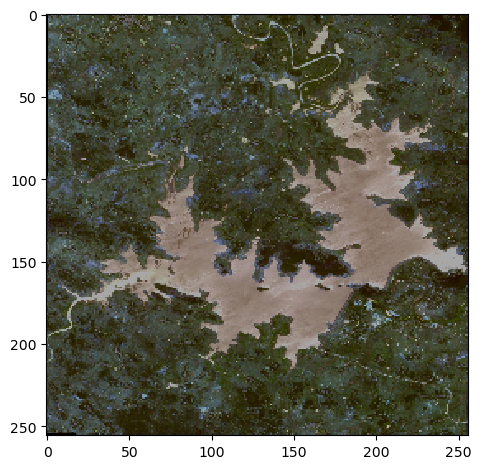

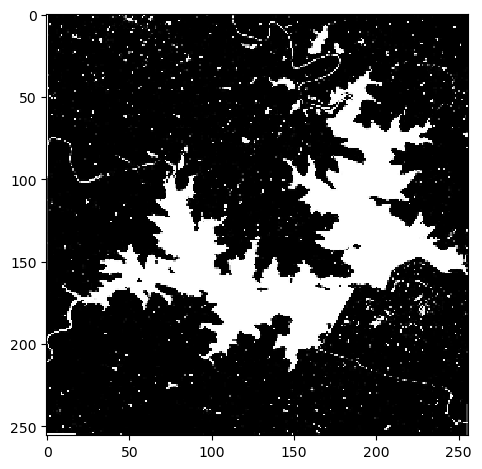

In [6]:
random_num = random.randint(0,516)
imshow(x[random_num])
plt.show()
imshow(y[random_num])
plt.show() 

test_img = x[random_num]
test_img2 = y[random_num]

## Разделим датасет

In [4]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

## U-NET model

In [5]:
#UNet model building
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [6]:
def get_model():
    return simple_unet_model(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)

## Сведения о сети

In [7]:
model = get_model()
#model.summary()

## Запустим

In [8]:
# softmax xD
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
history=model.fit(x_train,
          y_train,
          batch_size=10, 
          epochs=100,
          verbose=1,
          validation_data=(x_val, y_val))

Epoch 1/100
226/226 [==============================] - 11s 28ms/step - loss: 0.5233 - accuracy: 0.6268 - val_loss: 0.4843 - val_accuracy: 0.6507
Epoch 2/100
226/226 [==============================] - 5s 22ms/step - loss: 0.4601 - accuracy: 0.6629 - val_loss: 0.4628 - val_accuracy: 0.6611
Epoch 3/100
226/226 [==============================] - 5s 22ms/step - loss: 0.4249 - accuracy: 0.6864 - val_loss: 0.4185 - val_accuracy: 0.6944
Epoch 4/100
226/226 [==============================] - 5s 22ms/step - loss: 0.3960 - accuracy: 0.7007 - val_loss: 0.4150 - val_accuracy: 0.6987
Epoch 5/100
226/226 [==============================] - 5s 22ms/step - loss: 0.3582 - accuracy: 0.7184 - val_loss: 0.3783 - val_accuracy: 0.7185
Epoch 6/100
226/226 [==============================] - 5s 22ms/step - loss: 0.3349 - accuracy: 0.7285 - val_loss: 0.3386 - val_accuracy: 0.7317
Epoch 7/100
226/226 [==============================] - 5s 22ms/step - loss: 0.3259 - accuracy: 0.7325 - val_loss: 0.3477 - val_accuracy

## Графики показывающие результаты обучения

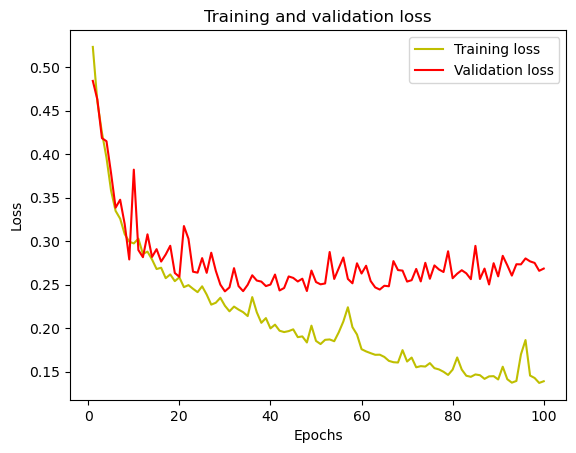

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

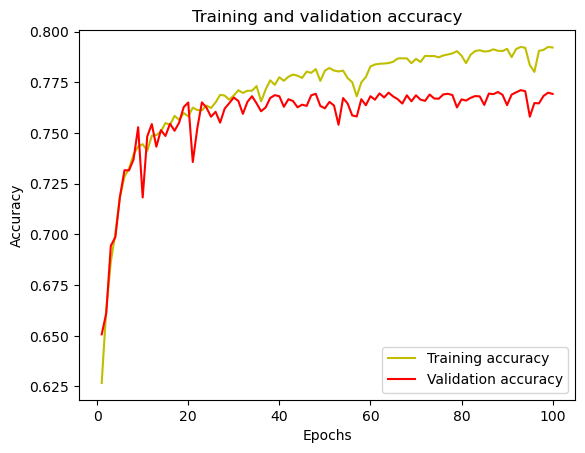

In [11]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Лучшие показатели

In [14]:
best_train_loss = min(history.history['loss'])
best_train_acc = max(history.history['accuracy'])

print(best_train_loss)
print(best_train_acc)

0.20058953762054443
0.7766562104225159


In [15]:
best_val_loss = min(history.history['val_loss'])
best_val_acc = max(history.history['val_accuracy'])

print(best_val_loss)
print(best_val_acc)

0.24812744557857513
0.7680370807647705


## Предсказания для 2х картинок

Original Image: 


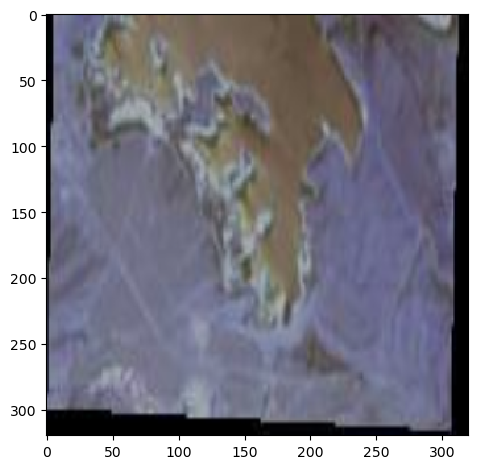

Predicted Mask: 


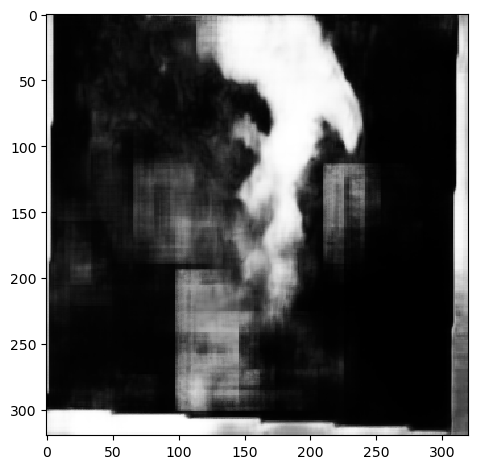

Original Image: 


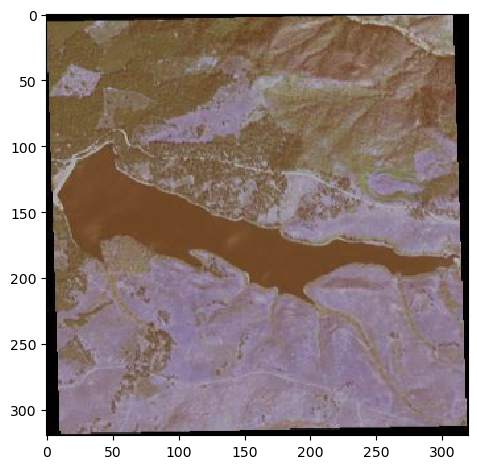

Predicted Mask: 


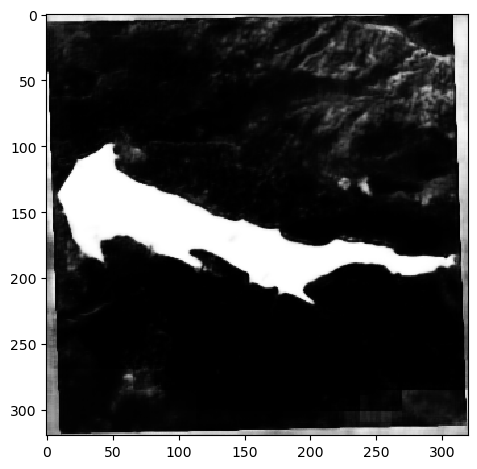

In [24]:
for i in range(0,2):    
    random_num = random.randint(0,500)
    original_image = x_val[random_num]
    imshow(original_image)
    print("Original Image: ")
    plt.show()

    original_image=np.expand_dims(original_image,axis=0)
    predicted_mask = model.predict(original_image)
    predicted_mask = predicted_mask.reshape(mask.shape)
    print("Predicted Mask: ")
    imshow(predicted_mask,cmap='grey')
    plt.show()
    i+=1

In [25]:
model.save("unet_classic_128px_200ep.h5")

In [110]:
#img=cv2.imread('tst2.jpg',cv2.IMREAD_COLOR)
#img=prep_image(img,crop_size,size_y,size_x)
#img = np.array(img)
#new_img = np.expand_dims(img, 0)

#pred_img = model.predict(new_img)
#pred_img = np.squeeze(pred_img)


#imshow(img)
#print("Оригинальная: ")
#plt.show()


#imshow(pred_img)
#print("Предксказанная: ")
#plt.show()